In [1]:
from typing import List, Optional
import urllib.request
from tqdm import tqdm
from pathlib import Path
import requests
import torch
import math
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import pandas as pd
import sklearn.metrics
import seaborn as sb
import umap

import torch.nn as nn
import scipy

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

import utils

In [2]:
# given the random seeds and arguments are the same, this "should" give the same train/test split..
# TODO: find better way to persist train/test split

utils.download_quickdraw_dataset(root="../data/npy", class_names = ['airplane', 'apple', 'wine bottle', 'car', 'mouth', 'pineapple', 'umbrella', 'pear', 'moustache', 'smiley face'] + ['train', 'mosquito', 'bee', 'dragon', 'piano'])
dataset = utils.QuickDrawDataset(root = "../data/npy", max_items_per_class=100000)

train_ds, val_ds = dataset.split(0.2)
validation_dataloader = DataLoader(val_ds, batch_size=1, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 13020.40it/s]


Loading 100000 examples for each class from the Quickdraw Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.76it/s]


In [3]:
model = nn.Sequential(
   nn.Conv2d(1, 16, 3, padding='same'),
   nn.ReLU(),
   nn.MaxPool2d(2),
   nn.Conv2d(16, 32, 3, padding='same'),
   nn.ReLU(),
   nn.MaxPool2d(2),
   nn.Conv2d(32, 32, 3, padding='same'),
   nn.ReLU(),
   nn.MaxPool2d(2),
   nn.Flatten(),
   nn.Linear(288, 128),
   nn.ReLU(),
   nn.Linear(128, len(dataset.classes)),
)

In [4]:
checkpoint = torch.load('./model_lessCapacity.pth',  map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=288, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=15, bias=True)
)

## Vanilla Gradients

In [70]:
def plot_vanilla_gradient(index):
    batch = dataset[index]
    x, y, idx = batch
    x.requires_grad_()
    x_batch = x.unsqueeze(dim=0)
    logits = model(x_batch)
    logits_idx = logits.argmax()
    logits_max = logits[0, logits_idx]
    
    #compute gradients
    logits_max.backward()
    
    #plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(x.grad.reshape(28,28,1), cmap='Greys')
    ax1.set_title(index)
    ax2.imshow(x.reshape(28,28,1).detach(), cmap='Greys')
    ax2.set_title((dataset.classes[dataset[index][1]]))
    plt.axis('off')

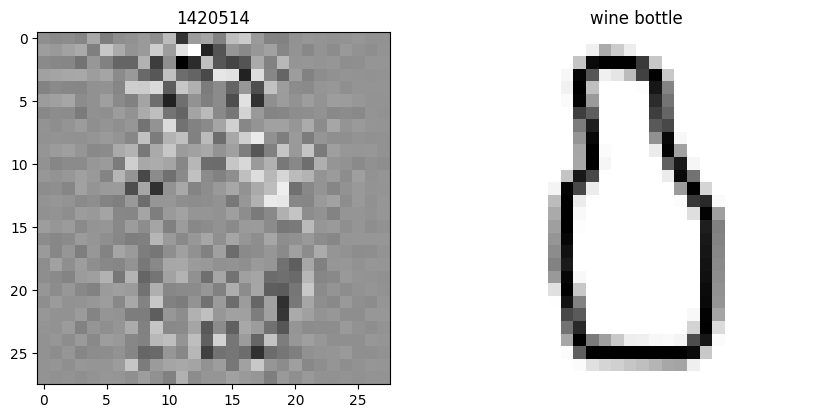

In [178]:
plot_vanilla_gradient(np.random.randint(0, len(dataset)))

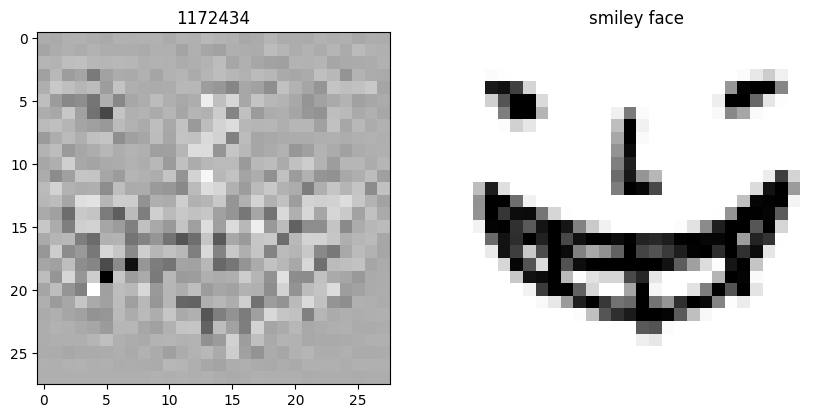

In [183]:
plot_vanilla_gradient(1172434)

## Input × Gradient 

In [1006]:
def plot_input_x_gradient(index):
    batch = dataset[index]
    x, y, idx = batch
    x.requires_grad_()
    x_batch = x.unsqueeze(dim=0)
    print(x_batch.shape)
    logits = model(x_batch)
    logits_idx = logits.argmax()
    logits_max = logits[0, logits_idx]
    
    #compute gradients
    logits_max.backward()
    
    #plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(x.grad.reshape(28,28,1) * x.reshape(28,28,1).detach(), cmap='Greys')
    ax1.set_title(index)
    ax2.imshow(x.reshape(28,28,1).detach(), cmap='Greys')
    ax2.set_title((dataset.classes[dataset[index][1]]))
    plt.axis('off')

torch.Size([1, 1, 28, 28])


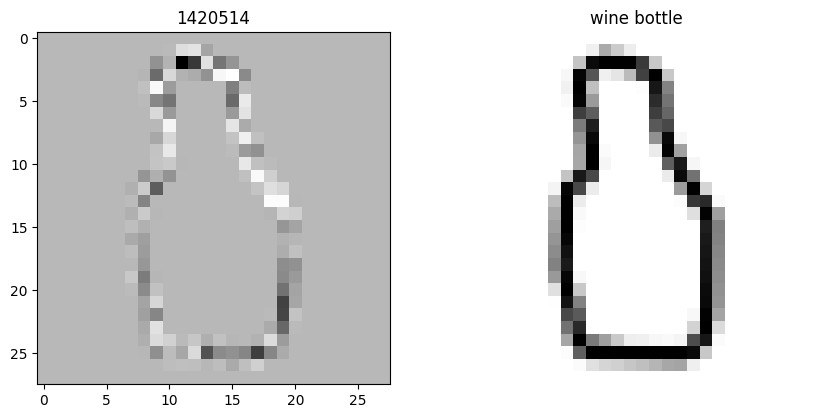

In [1007]:
plot_input_x_gradient(1420514)

## Grad Cam

In [241]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
           nn.Conv2d(1, 16, 3, padding='same'),
           nn.ReLU(),
           nn.MaxPool2d(2),
           nn.Conv2d(16, 32, 3, padding='same'),
           nn.ReLU(),
           nn.MaxPool2d(2),
           nn.Conv2d(32, 32, 3, padding='same'),
           nn.ReLU(),
           nn.MaxPool2d(2),
           nn.Flatten(),
           nn.Linear(288, 128),
           nn.ReLU(),
           nn.Linear(128, len(dataset.classes)),
        )
        
        self.gradients = None

    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        #apply all layers up to last conv layer
        x = self.model[:7](x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining layers
        x = self.model[7:](x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.model[:7](x)

In [233]:
grad_model = GradCamModel()

In [234]:
checkpoint = torch.load('./model_lessCapacity.pth',  map_location=torch.device('cpu'))
grad_model.model.load_state_dict(checkpoint)

grad_model.model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=288, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=15, bias=True)
)

In [372]:
def plot_grad_cam(index):
    batch = dataset[index]
    x, y, idx = batch
    x.requires_grad_()
    x_batch = x.unsqueeze(dim=0)

    logits = grad_model(x_batch)
    pred = logits.max()
    pred.backward()
    
    y_hat = np.argmax(logits.detach())
    
    gradients = grad_model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = grad_model.get_activations(x_batch).detach()
    for i in range(32):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)

    print(index)

    plt.figure()
    plt.imshow(x.reshape(28,28,1).detach(), cmap='Greys')
    plt.title(str(index) + " - true:" + dataset.classes[y]  + " - pred:" + dataset.classes[y_hat])
    plt.axis('off')

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    plt.imshow(heatmap.squeeze(), cmap='Reds', interpolation='nearest', alpha=.5, extent=(xmin,xmax,ymin,ymax))   # for heatmap to overlap

772846


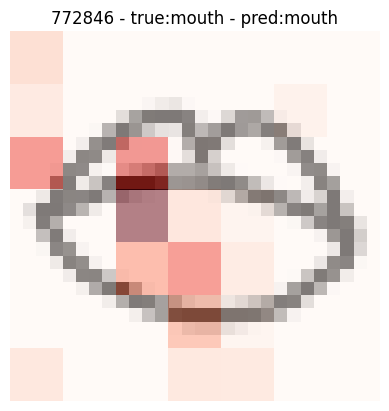

In [406]:
plot_grad_cam(np.random.randint(0, len(dataset)))

## Selected samples

In [407]:
df = pd.read_csv("evaluation_main_stats.csv")

In [411]:
completely_wrong = list(df[df.pred_prob_for_true_class < 0.01]['index'])

In [469]:
completely_wrong

[362404,
 1138672,
 615336,
 495430,
 792475,
 230678,
 1089110,
 846325,
 371355,
 411590,
 1070840,
 1173259,
 1008654,
 406517,
 454886,
 1418809,
 1213370,
 186830,
 142560,
 601381,
 465029,
 209828,
 1167738,
 710437,
 715432,
 246,
 614930,
 407213,
 932926,
 1241302,
 830359,
 1254117,
 455707,
 277523,
 75302,
 9202,
 1472386,
 646042,
 245100,
 1051329,
 347049,
 453729,
 556761,
 496220,
 40757,
 514478,
 575419,
 378460,
 984431,
 1313425,
 442945,
 570522,
 1225031,
 471562,
 446270,
 1323633,
 428946,
 113480,
 331744,
 1066408,
 220375,
 470738,
 1491442,
 777370,
 1016375,
 236179,
 4434,
 1040803,
 154434,
 94492,
 575356,
 1235335,
 208241,
 177638,
 895073,
 439317,
 880383,
 122542,
 1049544,
 129326,
 259644,
 493648,
 1064704,
 306509,
 360364,
 462070,
 624608,
 59896,
 1020896,
 868531,
 401516,
 172119,
 120143,
 1085614,
 1378144,
 697127,
 877557,
 511539,
 904989,
 322339,
 877897,
 628314,
 809910,
 336284,
 51375,
 664525,
 880259,
 768072,
 905503,
 26682

710557


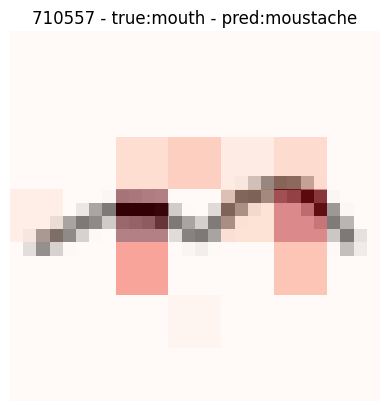

In [949]:
plot_grad_cam(completely_wrong[np.random.randint(0,len(completely_wrong))])

709918


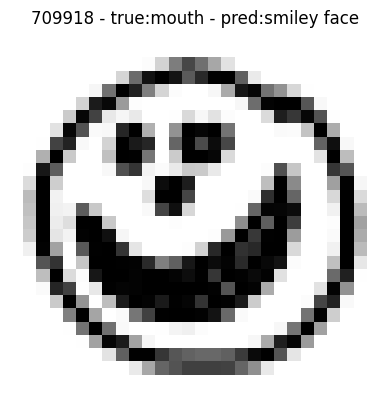

In [512]:
plot_grad_cam(709918)

In [730]:
half_wrong = list(df[(df.pred_prob_for_true_class > 0.45) & (df.pred_prob_for_true_class < 0.55)]['index'])

1458065


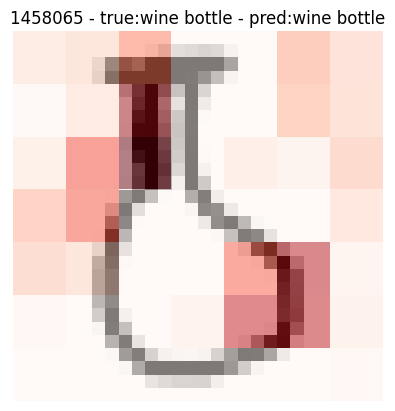

In [768]:
plot_grad_cam(half_wrong[np.random.randint(0,len(half_wrong))])

## Comparative Grad Cams

In [811]:
def plot_grad_cam_for_top_two(index):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    #compute once
    batch = dataset[index]
    x, y, idx = batch
    x.requires_grad_()
    x_batch = x.unsqueeze(dim=0)
    
    logits = grad_model(x_batch)
    y_hat = np.argmax(logits.detach())

    gradients = grad_model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])


    argmax1 = np.argsort(logits[0].detach())[-1].item()
    max1 = logits[0][argmax1]

    argmax2 = np.argsort(logits[0].detach())[-2].item()
    max2 = logits[0][argmax2]
    
    ## first grad cam
    max1.backward()
    
    activations = grad_model.get_activations(x_batch).detach()
    for i in range(32):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    
    ax1.imshow(x.reshape(28,28,1).detach(), cmap='Greys')
    ax1.set_title(dataset.classes[argmax1])
    ax1.set_axis_off()

    xmin, xmax = ax1.get_xlim()
    ymin, ymax = ax1.get_ylim()

    ax1.imshow(heatmap.squeeze(), cmap='Reds', interpolation='nearest', alpha=.5, extent=(xmin,xmax,ymin,ymax))   # for h
    
    grad_model.zero_grad()
    
    #compute again
    batch = dataset[index]
    x, y, idx = batch
    x.requires_grad_()
    x_batch = x.unsqueeze(dim=0)
    
    logits = grad_model(x_batch)
    y_hat = np.argmax(logits.detach())

    gradients = grad_model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    argmax1 = np.argsort(logits[0].detach())[-1].item()
    max1 = logits[0][argmax1]

    argmax2 = np.argsort(logits[0].detach())[-2].item()
    max2 = logits[0][argmax2]
    
    ## second grad cam
    max2.backward()
    
    activations = grad_model.get_activations(x_batch).detach()
    for i in range(32):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    
    ax2.imshow(x.reshape(28,28,1).detach(), cmap='Greys')
    ax2.set_title(dataset.classes[argmax2])
    ax2.set_axis_off()

    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()

    ax2.imshow(heatmap.squeeze(), cmap='Reds', interpolation='nearest', alpha=.5, extent=(xmin,xmax,ymin,ymax))   # for h
    
    grad_model.zero_grad()
    
    # plot histogram
    logits = logits.detach().numpy()
    probs = np.exp(logits)/np.exp(logits).sum()
    probs = probs[0]
    
    ax3.bar(range(len(probs)),probs, tick_label=dataset.classes)
    ax3.set_xticklabels(dataset.classes, rotation=90)
    ax3.set_title(index)

    print(index)


632318


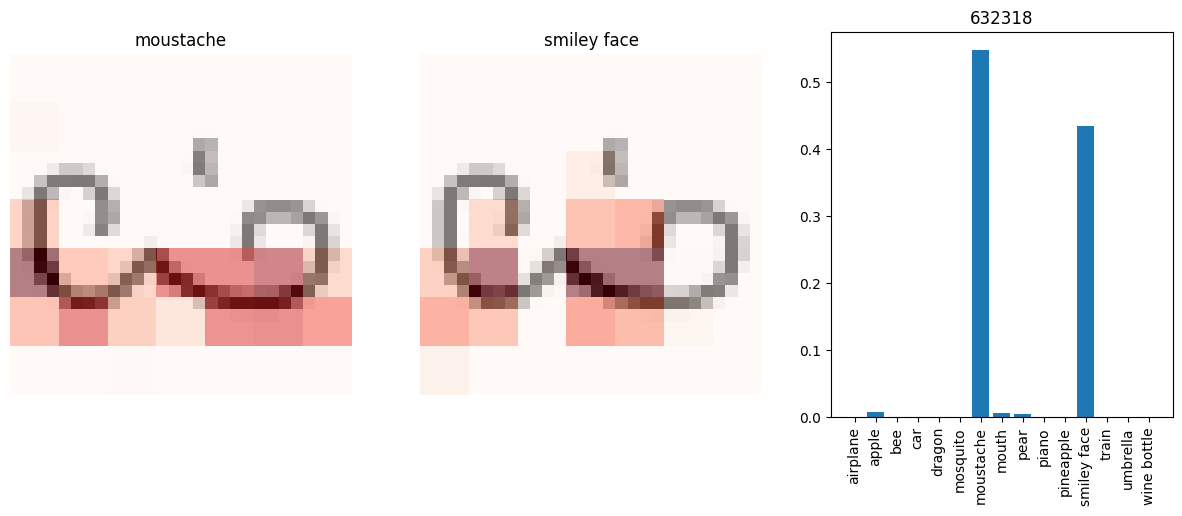

In [954]:
plot_grad_cam_for_top_two(half_wrong[np.random.randint(0,len(half_wrong))])

## Lime

In [ ]:
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [955]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [ ]:
def f(x):
    x = x.mean(axis=3, keepdims=True)
    x = x.reshape(10,1,28,28)
    return model(torch.Tensor(x)).detach().numpy()

In [1081]:
def lime(index):
    batch = dataset[index]
    x, y, idx = batch
    x.requires_grad_()
    x_batch = x.unsqueeze(dim=0).detach()

    x_batch = x_batch.reshape(28,28,1)

    b = np.repeat(x_batch[:, :, np.newaxis], 3, axis=2).squeeze()

    explanation = explainer.explain_instance(b.detach().numpy(), 
                                             classifier_fn = f, 
                                             top_labels=15, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
    
    fig, m_axs = plt.subplots(2,8, figsize = (12,6))
    plt.rcParams.update({'font.size': 6})
    for i, c_ax in enumerate(m_axs.flatten()):
        if i == 15:
            c_ax.set_axis_off()
            break
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=14, hide_rest=False, min_weight = 0.01 )
        c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
        c_ax.set_title('Positive for {}\nActual {}'.format(dataset.classes[i], dataset.classes[y]))
        if dataset.classes[i] == dataset.classes[y]:
            c_ax.set_title('Positive for {}\nActual {}'.format(dataset.classes[i], dataset.classes[y]), {'fontweight' : "bold"})
        c_ax.axis('off')
        
        

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 2.97 s, sys: 3.09 s, total: 6.06 s
Wall time: 1.72 s


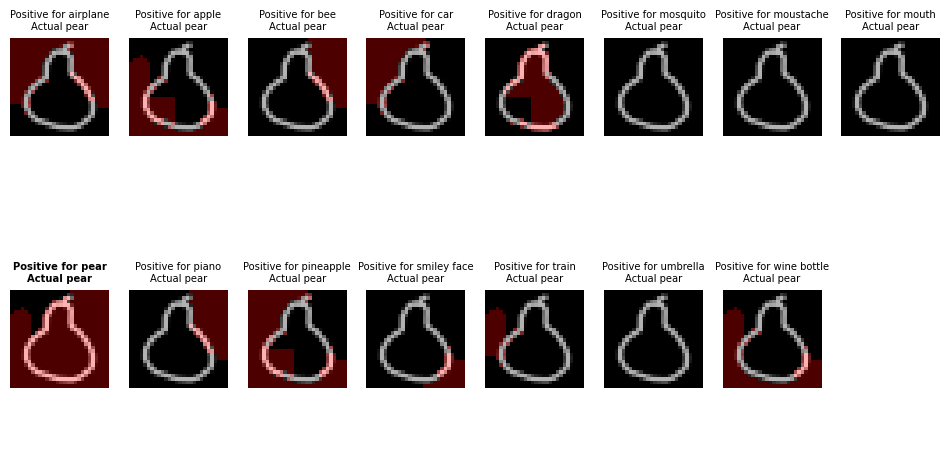

In [1082]:
%%time
lime(np.random.randint(0, len(dataset)))

# Umap

In [1115]:
import umap.plot

In [1089]:
from umap.umap_ import UMAP

In [1111]:
all_at_once = DataLoader(val_ds, batch_size=10000)
X_np = next(iter(all_at_once))[0].numpy()
X_np = X_np.reshape((10000,(28*28)))
Y_np = next(iter(all_at_once))[1].numpy()

In [1112]:
X_np.shape

(10000, 784)

In [1122]:
Y_np.reshape(10000)

array([14,  9,  9, ...,  0,  4,  7])

In [1125]:
embedding = UMAP().fit(X_np);

In [1137]:
Y_np.reshape(10000,1).shape

(10000, 1)

In [1142]:
labels = np.apply_along_axis(lambda x: dataset.classes[x[0]],1,Y_np.reshape(10000,1))

<Axes: >

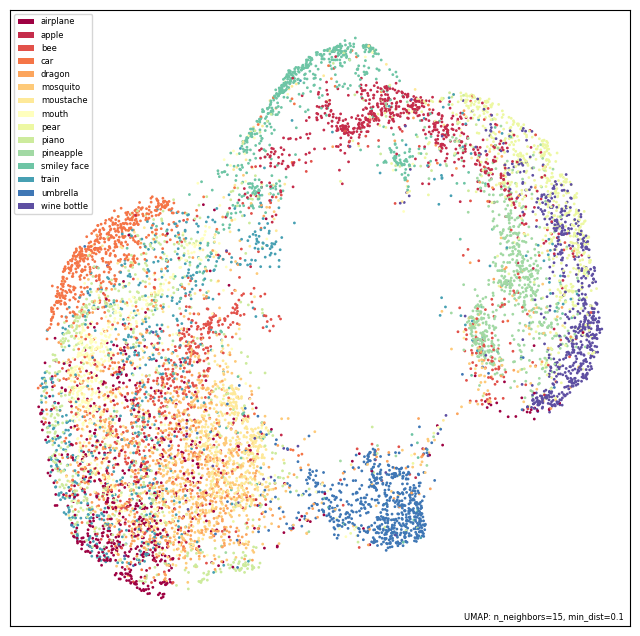

In [1143]:
umap.plot.points(embedding, labels=labels)

## Dknn

In [87]:
def get_df_intermediate_representation(layer):
    predictions = []
    for i, batch in tqdm(enumerate(validation_dataloader, 0)):
        x, y, idx = batch

        intermediate = model[:layer](x)
        logits = model[layer:](intermediate)

        logits = logits.detach().numpy()
        probs = np.exp(logits)/np.exp(logits).sum()

        y_hat = np.argmax(logits)

        predictions.append([idx, intermediate, y.item(), y_hat.item() ])

    df = pd.DataFrame(predictions, columns=["idx", "intermediate","y","y_hat"])
    df["idx"] = df["idx"].apply(lambda x : x.item())
    df["intermediate"] = df["intermediate"].apply(lambda x : x.detach().numpy())
    return df

In [95]:
def get_knn_for_layer(df, layer):
    knn_input = np.stack(df["intermediate"].apply(lambda x : x.flatten()))
    knn_labels = np.stack(df["idx"]).reshape(-1,1)
    
    tree = scipy.spatial.cKDTree(knn_input)
    
    def query(idx, k):
        
        query = dataset[idx][0]
        i_query = model[:layer](query).flatten().detach().numpy().reshape(1,-1)
        
        dd, ii = tree.query(i_query, k=list(range(k+1))[1:])
        return list(map((lambda x : knn_labels[x]), ii))
    
    return query

In [94]:
def plot_closest(idx_knn, query_f):
    k = 11

    e = query_f(idx_knn, k)

    fig, m_axs = plt.subplots(3,4, figsize = (12,6))
    for i, c_ax in enumerate(m_axs.flatten()):
        if(i==k):
            batch = dataset[idx_knn]
            x, y, idx = batch
            plt.imshow(x.reshape(28,28,1).detach(), cmap='Greys')
            plt.axis("off")
            plt.title("Input: " + str(idx) + "\n" + dataset.classes[y])
        else:
            batch = dataset[e[0][i].item()]
            x, y, idx = batch
            c_ax.set_title(str(idx) + " " + dataset.classes[y])
            c_ax.set_axis_off()
            c_ax.imshow(x.reshape(28,28,1).detach(), cmap='Greys')

In [96]:
df_layer_7 = get_df_intermediate_representation(7)
query_7 = get_knn_for_layer(df_layer_7, 7)

In [72]:
df_layer_10 = get_df_intermediate_representation(10)
query_10 = get_knn_for_layer(df_layer_10, 10)

300000it [05:01, 993.93it/s] 


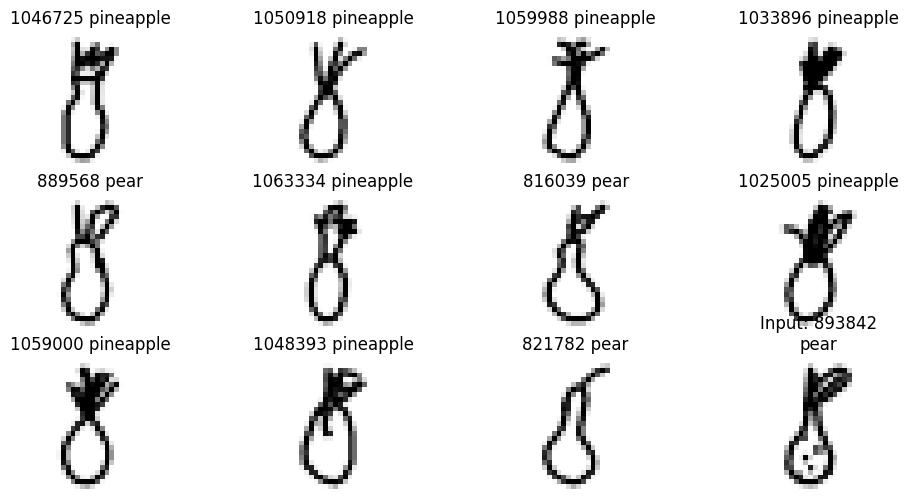

In [97]:
plot_closest(893842, query_7)

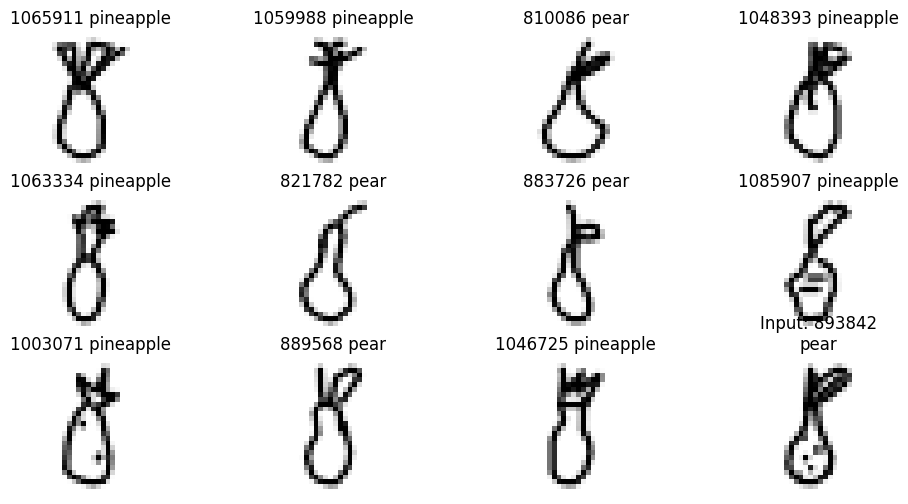

In [98]:
plot_closest(893842, query_10)